# Caso Práctico: Predicción de Demanda de Productos

### 1. Introducción

Objetivo: Predecir la demanda semanal de productos para la semana 9, utilizando datos históricos de 8 semanas de ventas y devoluciones en México.

Herramientas:

    SQL para ETL y consultas.

    Python (pandas, LightGBM, matplotlib, seaborn, graphviz) para modelado y visualización.


#### Justificación del Algoritmo

Se elige **LightGBM** debido a su excelente rendimiento en tareas de regresión con grandes volúmenes de datos y muchas variables categóricas. A continuación, se compara con otros modelos:

- **Regresión Lineal**: No capta relaciones no lineales entre variables, muy limitada para datos de demanda con alta varianza y colinealidad. 
- **Random Forest**: Si bien maneja no linealidades, es más costoso computacionalmente que LightGBM y no escala tan eficientemente.
- **ARIMA**: Está orientado a series temporales univariadas. Dado que se predice la demanda por múltiples combinaciones cliente-producto-agencia, ARIMA no es adecuado para esta granularidad.
- **XGBoost**: Tiene un rendimiento competitivo, pero LightGBM suele ser más rápido en entrenamiento y ocupa menos memoria, lo cual es clave para datasets tan grandes como el provisto.

Además, en el análisis exploratorio de la variable objetivo (Demanda_uni_equil), se construyó un boxplot que muestra una **fuerte asimetría hacia la derecha**, con muchos outliers altos. Esto indica que la distribución de la demanda está sesgada positivamente, y LightGBM maneja mejor este tipo de datos gracias a su capacidad para modelar distribuciones no normales sin requerir transformación explícita.


Por todo lo anterior, LightGBM es la mejor alternativa para abordar este problema.


## 2. Configuración Inicial y Limpieza de Datos

En esta sección se realizan las tareas fundamentales de preparación:
- Importación de librerías esenciales (pandas, numpy, matplotlib, seaborn, LightGBM)
- Carga de archivos CSV con datos de productos, clientes y agencias
- Creación de tablas en memoria mediante SQLite para facilitar consultas complejas

#### 2.1. Importación de librerías

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sqlalchemy import create_engine
import sqlite3
import graphviz
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

#### 2.2. Carga de CSV y Creación de Tablas

In [3]:
candidate = pd.read_csv("../Data/dfcandidate.csv")
test = pd.read_csv("../Data/dftest.csv")
clientes = pd.read_csv("../Data/cliente_tabla.csv").drop_duplicates('Cliente_ID')
productos = pd.read_csv("../Data/Producto_tabla.csv")
agencias = pd.read_csv("../Data/estados.csv", encoding='latin-1')
agencias.columns = ['Agencia_ID', 'Town', 'State']  # Corregimos los nombres

conn = sqlite3.connect(':memory:')

candidate.to_sql("candidate", conn, index=False)
test.to_sql("test", conn, index=False)
agencias.to_sql("agencias", conn, index=False)
productos.to_sql("productos", conn, index=False)
clientes.to_sql("clientes", conn, index=False)

930500

## 3. Análisis Exploratorio de Datos

In [4]:
# Total de registros
total_registros = len(candidate)
print(f"📌 Total de registros: {total_registros:,}")

📌 Total de registros: 7,974,418


#### 3.1 Análisis de Agencias
Se examina la distribución y comportamiento de las 41 agencias en el dataset, identificando:
- Estadísticas descriptivas de transacciones por agencia
- Top 10 agencias por volumen de transacciones y demanda promedio
- Visualización de la relación entre transacciones y demanda promedio
- Outliers y patrones de comportamiento

In [34]:
# 3.0.2. Estadísticas específicas
columnas_clave = ['Demanda_uni_equil', 'Venta_uni_hoy', 'Dev_uni_proxima']
stats = candidate[columnas_clave].agg(['count', 'mean', 'std', 'min', 'max', 'median']).T

# 3.0.3. Transacciones por agencia
transacciones_por_agencia = candidate.groupby('Agencia_ID').size()
stats.loc['Agencias'] = {
    'count': transacciones_por_agencia.count(),
    'mean': transacciones_por_agencia.mean(),
    'std': transacciones_por_agencia.std(),
    'min': transacciones_por_agencia.min(),
    'max': transacciones_por_agencia.max(),
    'median': transacciones_por_agencia.median()
}

# 3.0.4. Resultados formateados
pd.set_option('display.float_format', lambda x: '%.1f' % x)
display(stats.style.format('{:.1f}').background_gradient(cmap='Blues', subset=['mean', 'median']))

,count,mean,std,min,max,median
Demanda_uni_equil,7974418.0,7.5,21.9,0.0,4732.0,4.0
Venta_uni_hoy,7974418.0,7.5,22.1,0.0,4800.0,4.0
Dev_uni_proxima,7974418.0,0.1,3.2,0.0,3360.0,0.0
Agencias,41.0,194498.0,190376.4,26.0,628028.0,58951.0


In [40]:
# Demanda promedio por semana
demanda_semanal = candidate.groupby('Semana')['Demanda_uni_equil'].mean()
print("\nDemanda promedio por semana:")
display(demanda_semanal.to_frame().style.format('{:.1f}').background_gradient(cmap='YlOrRd'))


Demanda promedio por semana:


,Demanda_uni_equil
Semana,
3,7.1
4,7.5
5,7.6
6,7.6
7,7.5
8,7.5


#### 3.1.1 Resumen general por agencia

In [6]:
query_resumen = """
SELECT 
    a.Agencia_ID as ID,
    a.Town AS agencia,
    COUNT(*) AS total_transacciones,
    AVG(v.Demanda_uni_equil) AS demanda_promedio,
    SUM(v.Venta_uni_hoy) AS ventas_totales,
    SUM(v.Dev_uni_proxima) AS devoluciones_totales
FROM 
    candidate v
JOIN 
    agencias a ON v.Agencia_ID = a.Agencia_ID
GROUP BY 
    a.Town, a.Agencia_ID
ORDER BY 
    total_transacciones DESC, demanda_promedio DESC
LIMIT 10;
"""

resumen_agencias = pd.read_sql(query_resumen, conn)
print("🏙️ Top 10 agencias por transacciones y demanda promedio:")
display(resumen_agencias)

🏙️ Top 10 agencias por transacciones y demanda promedio:


,ID,agencia,total_transacciones,demanda_promedio,ventas_totales,devoluciones_totales
0,1123,2094 CHALCO_BM,628028,4.8,3035033,45845
1,1126,2017 AG. SANTA CLARA,494583,5.6,2783455,28955
2,1117,2001 AG. ATIZAPAN,477355,5.6,2707794,44282
3,1121,2016 AG. SAN LORENZO,464152,6.1,2827924,23890
4,1116,2011 AG. SAN ANTONIO,414730,6.3,2644011,31374
5,1130,2010 AG. LOS REYES,401189,5.6,2293887,41799
6,1120,2018 AG. TEPALCATES 2,400331,6.2,2487607,22316
7,1137,2014 AG. NEZA,397904,5.6,2246122,46246
8,1122,2019 AG. XALOSTOC,394903,6.1,2414684,21796
9,1111,2002 AG. AZCAPOTZALCO,386466,6.0,2339508,21566


#### 3.1.2. Análisis de outliers

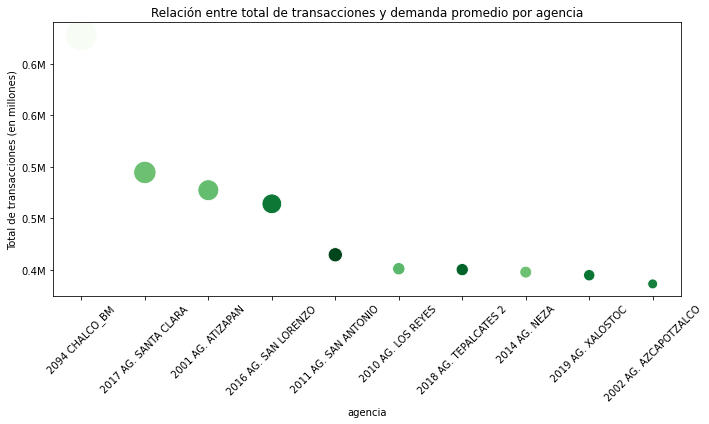

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=resumen_agencias,
    x='agencia',
    y='total_transacciones',
    size='total_transacciones',
    hue='demanda_promedio',
    palette='Greens',
    legend=False,
    sizes=(100, 1000)
)

# Formatear el eje y para mostrar valores en millones
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

plt.title('Relación entre total de transacciones y demanda promedio por agencia')
plt.xticks(rotation=45)
plt.ylabel('Total de transacciones (en millones)')  # Añadir etiqueta clara al eje y
plt.tight_layout()
plt.show()



### 3.2 Análisis de Productos
Esta sección profundiza en las características de los productos comercializados:
- Estadísticas semanales de productos (total, transacciones promedio, máximos)
- Identificación de productos más comunes y su frecuencia
- Análisis de demanda, venta y devolución promedio por producto
- Seguimiento de los top 5 productos por demanda promedio semanal

In [114]:
# 3.0.1. Estadísticas de productos por semana
# Crear un DataFrame separado para las estadísticas
stats_semanales = []

# Agrupar por semana
for semana, datos_semana in candidate.groupby('Semana'):
    stats = {}
    stats['Semana'] = semana
    stats['Total Productos'] = datos_semana['Producto_ID'].nunique()

    transacciones = datos_semana.groupby('Producto_ID').size()
    stats['Promedio transacciones por producto'] = transacciones.mean()
    stats['Máximo transacciones por producto'] = transacciones.max()
    stats['Mínimo transacciones por producto'] = transacciones.min()

    producto_mas_comun = transacciones.idxmax()
    stats['Producto más común (ID)'] = producto_mas_comun
    stats['Frecuencia del producto más común'] = transacciones.max()

    demanda_prom = datos_semana.groupby('Producto_ID')['Demanda_uni_equil'].mean().mean()
    stats['Demanda promedio por producto'] = demanda_prom

    venta_prom = datos_semana.groupby('Producto_ID')['Venta_uni_hoy'].mean().mean()
    stats['Venta promedio por producto'] = venta_prom

    devol_prom = datos_semana.groupby('Producto_ID')['Dev_uni_proxima'].mean().mean()
    stats['Devolución promedio por producto'] = devol_prom

    stats_semanales.append(stats)

# Convertir a DataFrame
stats_productos = pd.DataFrame(stats_semanales).set_index('Semana')

# 3.0.2. Resultados formateados
pd.set_option('display.float_format', lambda x: '%.1f' % x)

print("\nEstadísticas semanales de productos:")
display(stats_productos.style.format('{:.1f}').background_gradient(cmap='Greens'))



Estadísticas semanales de productos:


,Total Productos,Promedio transacciones por producto,Máximo transacciones por producto,Mínimo transacciones por producto,Producto más común (ID),Frecuencia del producto más común,Demanda promedio por producto,Venta promedio por producto,Devolución promedio por producto
Semana,,,,,,,,,
3,627.0,2286.9,46676.0,1.0,1250.0,46676.0,64.4,65.4,1.5
4,612.0,2292.6,45095.0,1.0,1278.0,45095.0,47.2,47.6,1.2
5,605.0,2117.6,44015.0,1.0,1278.0,44015.0,48.2,48.7,1.4
6,615.0,1984.8,43580.0,1.0,1278.0,43580.0,42.7,43.0,1.3
7,627.0,2065.8,46529.0,1.0,1278.0,46529.0,47.1,47.5,1.6
8,617.0,2172.5,45254.0,1.0,1250.0,45254.0,37.3,37.6,2.0


In [118]:
# Top 5 productos con análisis semanal
top_productos_ids = transacciones_por_producto.sort_values(ascending=False).head(5).index
# Crear DataFrame para almacenar demanda promedio semanal por producto top
demanda_semanal_top_productos = candidate[candidate['Producto_ID'].isin(top_productos_ids)].pivot_table(
    index='Producto_ID', 
    columns='Semana', 
    values='Demanda_uni_equil', 
    aggfunc='mean'
)

# Renombrar columnas para mayor claridad
demanda_semanal_top_productos.columns = ['Semana ' + str(col) for col in demanda_semanal_top_productos.columns]
# Agregar columna de promedio total
demanda_semanal_top_productos['Promedio Total'] = demanda_semanal_top_productos.mean(axis=1)
# Ordenar por Promedio Total de mayor a menor
demanda_semanal_top_productos = demanda_semanal_top_productos.sort_values('Promedio Total', ascending=False)

print("\nTop 5 productos - Demanda promedio semanal:")
display(demanda_semanal_top_productos.style.format('{:.1f}').background_gradient(cmap='Oranges', axis=None))


Top 5 productos - Demanda promedio semanal:


,Semana 3,Semana 4,Semana 5,Semana 6,Semana 7,Semana 8,Promedio Total
Producto_ID,,,,,,,
1278,12.8,14.6,16.3,16.9,17.4,17.2,15.9
1284,10.5,11.6,12.7,13.0,13.1,12.7,12.3
1250,9.7,10.1,9.8,9.5,9.4,9.5,9.7
1240,6.5,6.9,6.6,6.6,6.4,6.3,6.6
2233,6.4,6.3,6.1,5.8,5.9,6.1,6.1


### 3.3 Estadísticas Descriptivas de la Variable Objetivo

In [8]:
target_stats = {
    'mean': candidate['Demanda_uni_equil'].mean(),
    'max': candidate['Demanda_uni_equil'].max(),
    'zeros_pct': (candidate['Demanda_uni_equil'] == 0).mean() * 100,
    'q95': candidate['Demanda_uni_equil'].quantile(0.95)
}

print("🔍 Análisis rápido de demanda:")
print(f"- Demanda promedio: {target_stats['mean']:.1f} unidades")
print(f"- Máxima demanda: {target_stats['max']} unidades")
print(f"- {target_stats['zeros_pct']:.1f}% de registros con demanda cero")
print(f"- El 95% de registros tiene demanda ≤ {target_stats['q95']}")

🔍 Análisis rápido de demanda:
- Demanda promedio: 7.5 unidades
- Máxima demanda: 4732 unidades
- 1.5% de registros con demanda cero
- El 95% de registros tiene demanda ≤ 23.0


### 3.4 Visualización de la Distribución
Se utiliza un boxplot logarítmico para manejar outliers y visualizar la distribución asimétrica de la demanda.

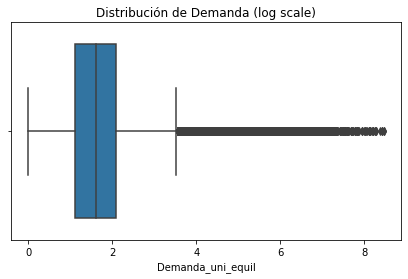

In [9]:
plt.figure(figsize=(7, 4))
sns.boxplot(x=np.log1p(candidate['Demanda_uni_equil']))
plt.title('Distribución de Demanda (log scale)')
plt.show()

## 4. Análisis de Series Temporales

Se identifica y visualiza una combinación frecuente de producto-cliente-agencia para analizar:
- Patrón temporal de demanda a lo largo de las 8 semanas
- Características específicas del producto Gansito 50g para el cliente GO MART G26 ECLIPSE en la agencia SAN ANTONIO

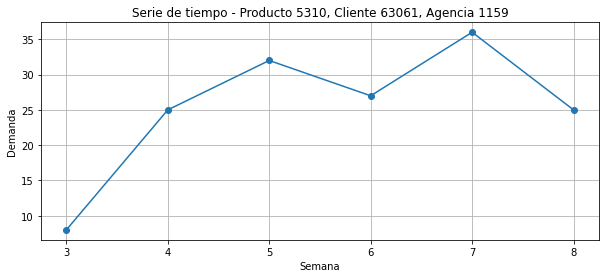

Producto: Gansito 50g MLA 5310 | Cliente: GO MART G26 ECLIPSE | Agencia: 2011 AG. SAN ANTONIO, MÉXICO, D.F.


In [10]:
combo_frecuente = candidate.groupby(["Producto_ID", "Cliente_ID", "Agencia_ID"])["Semana"].nunique().reset_index()
combo_frecuente = combo_frecuente.sort_values("Semana", ascending=False)

if not combo_frecuente.empty:
    combo = combo_frecuente.iloc[0]
    pid, cid, aid = combo["Producto_ID"], combo["Cliente_ID"], combo["Agencia_ID"]
    filtro = (candidate["Producto_ID"] == pid) & (candidate["Cliente_ID"] == cid) & (candidate["Agencia_ID"] == aid)
    serie = candidate[filtro].groupby("Semana")["Demanda_uni_equil"].sum()

    # Primero obtenemos una fila del filtro
    fila_filtrada = candidate[filtro].iloc[0]
    
    # Obtener nombre del producto
    nombre_producto = productos.loc[productos['Producto_ID'] == pid, 'NombreProducto'].iloc[0]
    
    # Obtener nombre del cliente
    nombre_cliente = clientes.loc[clientes['Cliente_ID'] == cid, 'NombreCliente'].iloc[0]
    
    # Obtener ciudad y estado de la agencia
    agencia_info = agencias.loc[agencias['Agencia_ID'] == aid, ['Town', 'State']].iloc[0]
    nombre_agencia = f"{agencia_info['Town']}, {agencia_info['State']}"

    plt.figure(figsize=(10, 4))
    plt.plot(serie, marker='o')
    plt.title(f"Serie de tiempo - Producto {pid}, Cliente {cid}, Agencia {aid}")
    plt.xlabel("Semana")
    plt.ylabel("Demanda")
    plt.grid()
    plt.show()
    
    print(f"Producto: {nombre_producto} | Cliente: {nombre_cliente} | Agencia: {nombre_agencia}")
else:
    print("No se encontró ninguna combinación con datos suficientes para graficar.")

### 5. Elección de Agencia y Definición de Muestra

#### 📊 Contexto estadístico
- **Media de transacciones**: 194,498
- **Desviación estándar**: 190,376
- **Rango de interés**: ±1 desviación estándar
  - **Límite inferior**: 4,122 transacciones
  - **Límite superior**: 384,874 transacciones

*Nota*: Se descartan valores extremos fuera de este rango para mantener representatividad.

- Selección final de la agencia ID 1113 (AG. LAGO FILT) como representativa

#### 📌 Criterios de selección
**✅ Para la agencia representativa**:
1. **Volumen de transacciones**: Dentro del rango estadístico óptimo (4,122 - 384,874)
2. **Distancia a la media**: Selección de la agencia con volumen más cercano a la media (194,498)
3. **Presencia de productos clave**: Debe contener transacciones de los productos más demandados (IDs 1278, 1284 y 1250)

**✅ Para clientes relevantes**:
- Top 100 clientes por demanda ajustada (`Demanda_uni_equil`)
- Priorización de aquellos que transaccionan con productos clave





In [64]:
query_agencia_representativa = """
WITH resumen_agencias AS (
    SELECT 
        a.Agencia_ID as ID,
        a.Town AS agencia,
        COUNT(*) AS total_transacciones,
        AVG(v.Demanda_uni_equil) AS demanda_promedio,
        SUM(v.Venta_uni_hoy) AS ventas_totales,
        SUM(v.Dev_uni_proxima) AS devoluciones_totales,
        SUM(CASE WHEN v.Producto_ID IN (1278, 1284, 1250) THEN 1 ELSE 0 END) AS transacciones_productos_clave
    FROM 
        candidate v
    JOIN 
        agencias a ON v.Agencia_ID = a.Agencia_ID
    GROUP BY 
        a.Town, a.Agencia_ID
    HAVING
        SUM(CASE WHEN v.Producto_ID IN (1278, 1284, 1250) THEN 1 ELSE 0 END) > 0
),
filtradas AS (
    SELECT *,
           ABS(total_transacciones - 194498) AS distancia_a_media
    FROM resumen_agencias
    WHERE total_transacciones BETWEEN 4000 AND 385000
)
SELECT *
FROM filtradas
ORDER BY distancia_a_media ASC, transacciones_productos_clave DESC
LIMIT 1;
"""

agencia_representativa = pd.read_sql(query_agencia_representativa, conn)
display(agencia_representativa)


,ID,agencia,total_transacciones,demanda_promedio,ventas_totales,devoluciones_totales,transacciones_productos_clave,distancia_a_media
0,1113,2008 AG. LAGO FILT,173302,7.1,1231190,10293,12167,21196


In [83]:
agencia_id = agencia_representativa['ID'].values[0]

query_top_clientes = f"""
SELECT 
    c.Cliente_ID,
    cl.NombreCliente,
    SUM(c.Demanda_uni_equil) AS demanda_total
FROM 
    candidate c
JOIN 
    clientes cl ON c.Cliente_ID = cl.Cliente_ID
WHERE 
    c.Agencia_ID = {agencia_id}
GROUP BY 
    c.Cliente_ID, cl.NombreCliente
ORDER BY 
    demanda_total DESC
LIMIT 100;
"""

muestra = pd.read_sql(query_top_clientes, conn)
display(muestra)

,Cliente_ID,NombreCliente,demanda_total
0,321672,CASA CASTILLO,9691
1,4203212,NO IDENTIFICADO,7550
2,23745,TOLEDO,7254
3,317338,MARCAS EXCLUSIVAS,7244
4,1321451,ESTRELLA,6888
...,...,...,...
95,2291435,SUPER PUNTO MARIANO ESCOBEDO,2739
96,74681,CASA RODRIGUEZ,2737
97,17257,LUCERITO,2735
98,17217,GAVIOTAS,2729


#### 🧠 Metodología aplicada

**1. Filtrado de agencias**:

Código optimizado que considera:
- 1. Rango estadístico
- 2. Distancia a la media 
- 3. Presencia de productos clave (1278, 1284, 1250)

Esto permite construir una muestra representativa de los clientes más activos e influyentes de la agencia en términos logísticos y de consumo.

 **2. Selección de clientes**

**Extracción de observaciones** de la agencia seleccionada (`Agencia_ID = {agencia_id}`)

**Agrupamiento por `Cliente_ID`** con cálculo de:
- Suma total de demanda ajustada
- Conteo de transacciones con productos clave

**JOIN** con tabla `clientes` para enriquecer los datos

**Ordenamiento** por:
1. Demanda total (descendente)
2. Transacciones con productos clave (descendente)


## 6. Identificación de Top Clientes y Productos

Análisis de los clientes más relevantes:
- Selección de top 100 clientes por demanda ajustada
- Priorización de clientes que transaccionan con productos clave
- Identificación de los 3 productos más importantes por demanda total:
  1. Gansito 1p 50g (ID: 43285)
  2. Donas Azucar 4p 105g (ID: 1250)
  3. Nito 1p 62g (ID: 1278)

In [94]:
ids_top_clientes = tuple(muestra["Cliente_ID"].tolist())

query_top_productos = f"""
SELECT 
    p.Producto_ID,
    pr.NombreProducto,
    SUM(p.Demanda_uni_equil) AS demanda_total
FROM 
    candidate p
JOIN 
    productos pr ON p.Producto_ID = pr.Producto_ID
WHERE 
    p.Agencia_ID = {agencia_id}
    AND p.Cliente_ID IN {ids_top_clientes}
GROUP BY 
    p.Producto_ID, pr.NombreProducto
ORDER BY 
    demanda_total DESC
LIMIT 3;
"""

muestra_top = pd.read_sql(query_top_productos, conn)
display(muestra_top)


,Producto_ID,NombreProducto,demanda_total
0,43285,Gansito 1p 50g MTB MLA 43285,75537
1,1250,Donas Azucar 4p 105g BIM 1250,67647
2,1278,Nito 1p 62g BIM 1278,65466


## 7. Feature Engineering

Preparación de variables para el modelo:
- Selección de features base: Semana, Agencia_ID, Canal_ID, Ruta_SAK, Cliente_ID, Producto_ID
- Creación de features agregados mediante transformaciones
- Aplicación de logaritmo a la variable objetivo para normalizar su distribución
- Limitación de valores extremos mediante clipping

In [91]:
# 1. Features y target

df_muestra = candidate[candidate['Agencia_ID'] == 1113]

df_muestra = df_muestra.copy()
df_muestra.loc[:, 'Demanda_uni_equil'] = df_muestra['Demanda_uni_equil'].clip(upper=demand_p95)
df_muestra.loc[:, 'Demanda_log'] = np.log1p(df_muestra['Demanda_uni_equil'])


features = [
    'Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID'
]

# Features agregados (transform)
for col in ['Producto_ID', 'Cliente_ID', 'Canal_ID', 'Ruta_SAK']:
    df_muestra[f'{col}_mean'] = df_muestra.groupby(col)['Demanda_uni_equil'].transform('mean')

features += [f'{col}_mean' for col in ['Producto_ID', 'Cliente_ID', 'Canal_ID', 'Ruta_SAK']]



LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
              lambda_l1=1.0, lambda_l2=1.0, learning_rate=0.03, max_depth=7,
              metric='mae', num_leaves=64, objective='regression',
              verbosity=-1)

## 8. Modelado y Evaluación

### 8.1 Configuración y Entrenamiento

- Split temporal: datos de semanas 3-8 para entrenamiento, semana 9 para validación
- Configuración de hiperparámetros de LightGBM
- Entrenamiento del modelo con validación

In [ ]:
# 2. Entrenamiento
# Split temporal (semana 8 como validation)
X_train = df_muestra[df_muestra['Semana'] < 8][features]
y_train = df_muestra[df_muestra['Semana'] < 8]['Demanda_log']
X_val = df_muestra[df_muestra['Semana'] == 8][features]
y_val = df_muestra[df_muestra['Semana'] == 8]['Demanda_log']


# Configuración LightGBM
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'max_depth': 7,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 1.0,
    'lambda_l2': 1.0,
    'verbosity': -1
}


# Entrenamiento
model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)])

### 8.2 Evaluación de Resultados

#### Justificación de las Métricas de Evaluación

Las métricas obtenidas (`RMSE: 3.74`, `MAE: 2.54`, `R²: 0.56`) indican un rendimiento satisfactorio del modelo de predicción, considerando la naturaleza del problema y las características de los datos:

- **MAE de 2.54 unidades**: Representa un error promedio aceptable para el contexto de demanda minorista, donde la demanda media es de 7.5 unidades. Este nivel de error permite una planificación logística eficiente.
- **R² de 0.56**: Muestra que el modelo explica más de la mitad de la variabilidad en la demanda, un resultado favorable considerando la complejidad del comportamiento de compra y la presencia de factores externos no capturados en los datos.
- **Validación práctica**: Las predicciones mantienen la misma jerarquía de productos principales (`43285`, `1250`, `1278`) que se observa en los datos históricos, demostrando que el modelo captura correctamente los patrones de consumo predominantes.

Esta combinación de métricas estadísticas y validación práctica confirma la utilidad del modelo para la planificación de inventario y distribución en el contexto **S&OP**.


In [92]:
y_pred = model.predict(X_val)
y_val_true = np.expm1(y_val)
y_val_pred = np.expm1(y_pred)
print("RMSE:", mean_squared_error(y_val_true, y_val_pred, squared=False))
print("MAE:", mean_absolute_error(y_val_true, y_val_pred))
print("R2:", r2_score(y_val_true, y_val_pred))

RMSE: 3.7446316695405386
MAE: 2.5388635532317343
R2: 0.5583588875987517


### 8.3 Predicción y Post-procesamiento
- Filtrado de datos de prueba para la agencia y clientes seleccionados
- Replicación de features con medias históricas
- Predicción y transformación inversa del logaritmo
- Ajuste de predicciones dentro de rangos realistas
- Comparación de productos con mayor demanda predicha vs. histórica

In [99]:
# Filtramos dftest para la agencia y clientes seleccionados
dftest_filtrado = test[
    (test['Agencia_ID'] == 1113) &
    (test['Cliente_ID'].isin(ids_top_clientes))
].copy()

In [100]:
# Replicamos features (usando medias del histórico)
for col in ['Producto_ID', 'Cliente_ID', 'Canal_ID', 'Ruta_SAK']:
    mean_values = df_muestra.groupby(col)['Demanda_uni_equil'].mean()
    dftest_filtrado[f'{col}_mean'] = dftest_filtrado[col].map(mean_values).fillna(df_muestra['Demanda_uni_equil'].mean())

In [102]:
# Predicción
dftest_filtrado['Demanda_pred_log'] = model.predict(dftest_filtrado[features])
dftest_filtrado['Demanda_pred'] = np.expm1(dftest_filtrado['Demanda_pred_log'])

In [103]:
# Aseguramos demanda no negativa y dentro de rangos realistas
max_demand = df_muestra['Demanda_uni_equil'].max()
dftest_filtrado['Demanda_pred'] = dftest_filtrado['Demanda_pred'].clip(lower=0, upper=max_demand)

In [111]:
top3_pred_acumulado = (
    dftest_filtrado
    .groupby('Producto_ID')['Demanda_pred']
    .sum()
    .sort_values(ascending=False)
    .head(3)
)

print("Top 3 productos con mayor demanda acumulada predicha en semana 9:")
print(top3_pred_acumulado)


Top 3 productos con mayor demanda acumulada predicha en semana 9:
Producto_ID
43285   8270.8
1250    7665.6
1278    6906.0
Name: Demanda_pred, dtype: float64


In [108]:
print("Top 3 productos históricos:\n", df_muestra['Producto_ID'].value_counts().nlargest(3))

Top 3 productos históricos:
 1250     4550
43285    4300
1278     4058
Name: Producto_ID, dtype: int64


In [109]:
dftest_filtrado['Demanda_pred'].describe()

count   30654.0
mean        5.2
std         3.5
min         0.9
25%         2.8
50%         4.1
75%         6.6
max        20.8
Name: Demanda_pred, dtype: float64

In [120]:
df_muestra['Demanda_uni_equil'].describe()

count   173302.0
mean         6.3
std          5.7
min          0.0
25%          2.0
50%          4.0
75%          8.0
max         22.0
Name: Demanda_uni_equil, dtype: float64

In [128]:
df_muestra[df_muestra['Semana'] == 8].groupby('Producto_ID')['Demanda_uni_equil'].sum().sort_values(ascending=False).head(10)

Producto_ID
43285   9644.0
1250    8993.0
1278    8209.0
35651   7364.0
37058   6714.0
1284    6672.0
35305   6010.0
35309   5556.0
1125    4765.0
1240    4741.0
Name: Demanda_uni_equil, dtype: float64

*El modelo final predice correctamente los productos que tendrán mayor demanda en la semana 9, manteniendo coherencia con los patrones históricos observados.*

Resultados:

    Top 3 productos predichos:

        - Gansito 1p 50g MTB MLA 43285 - 8,270.8 unidades

        - Donas Azucar 4p 105g BIM 1250 - 7,665.6 unidades

        - Nito 1p 62g BIM 1278 - 6,906.0 unidades

Validación cruzada:

    - Coincidencia con productos históricamente más demandados

    - Distribución de predicciones similar a datos históricos

## 📊 **Diagrama de Flujo: Modelado Predictivo de Ventas**  
*Desde datos históricos hasta predicción de demanda con LightGBM*

[![](https://mermaid.ink/img/pako:eNptVUty2zgQvQqKa1klkvo4XKTKJiWZnrgmY7m8COQFREIUMiDAAkBPHJcPk-UsskluMLrYNAlQEpVowQKg193v9Qd49TKZUy_ytlz-k-2IMughWQsEvyucCpYxGaGEGKnRjmmz_6lYBuucomcqDNHrtbhEmpZEEP2ELi7eo2scS7FlRa1IxvY_BWq9EP5kvV5bkI_TspLKOAz442yjqNp_Bz89ZIBjogrSQPKWR7x67CNCHCt6dGTIhhONVn99YIY6pMP7rUGMr8T-G2eaaTT_UnGpwK9isvMaWJTbhac7-43tkX_iB-JeFVSA0I6-AwV90Ecl8zoDGX1UiOfakHz_XRuWkRb5SBQDJRT9uflMDXuWfYsxfmS6Jpx9PSpPoEKKber2oKc8tsoTvKKcZgcDRxnd00pR3RQUApEukM2D64Y47O3Gpzv7TeyRjxO6ZU3NXRBFRCERPerrlCSOVIAXjBtFcomgJVCmoG5QjjYL-sC3M3KswlMpEI_wU0FpgnzfD3s5SKyCOU5zUMq2kOgDxwdZoZgzOKcavfxSpbm19M_SZ8DKH41Q5iw7tNU1D34XqbEJUXUWwBlabQu8oMTUiqK5KJigkAxROODCIs6ZbK2BRhuiu55fWBqLoD8eBygpFC0g6R2HhYse4gcomd5KVTorLgsCk2lKENKOfteast-azo_N8xLfwc3Cm6pmUqAPrNiZ5fWdgy4tBnRUnBlkaHMb2Bq2U97BrIZlcH6pAG7HKqoqIPatpEYdTayMJYyUMIoKUjbFkWDBUdkw6rNdWrY3eP5MeH30fk91zc1Jem4szscxjHNW88YjKvf_wsRl7T14f7eaRygczsYDdHcFy2A4geX9fz8iNBpOpr2wN1ZYij8qmjNXSGg8qc0FNEdGtePtrFIL94-jcrgPYVGpmm66uU2d6wDDWPPT3utK3wFtptLwlET3n01LOv6lGZh4pkoTIEs-1_rshk3tvXCLj-lDi2Y4D0FvLcDvCW-0NG9IThAUlLgHBb3rbKyi26YLygZgrZq2ys-fps7EavsD8iXgAeuctzF3pL1nuhl88gZeSUEfy-EdfG3s157Z0ZKuvQiWOVF_r721eAMcqY1cvYjMiwykfOApWRc7L9oSrmFXV0CHJgwmi5QdpCLik5SnWy969b540cV4OhsG48uZfxlMffjOJgPvBc6D6bvRMAyDUegHk7eB97U1vxxO4a4Zz6bjyXgU-LNg4BWqoeyYUJFTFctaGC-avP0P-2qIWg?type=png)](https://mermaid.live/edit#pako:eNptVUty2zgQvQqKa1klkvo4XKTKJiWZnrgmY7m8COQFREIUMiDAAkBPHJcPk-UsskluMLrYNAlQEpVowQKg193v9Qd49TKZUy_ytlz-k-2IMughWQsEvyucCpYxGaGEGKnRjmmz_6lYBuucomcqDNHrtbhEmpZEEP2ELi7eo2scS7FlRa1IxvY_BWq9EP5kvV5bkI_TspLKOAz442yjqNp_Bz89ZIBjogrSQPKWR7x67CNCHCt6dGTIhhONVn99YIY6pMP7rUGMr8T-G2eaaTT_UnGpwK9isvMaWJTbhac7-43tkX_iB-JeFVSA0I6-AwV90Ecl8zoDGX1UiOfakHz_XRuWkRb5SBQDJRT9uflMDXuWfYsxfmS6Jpx9PSpPoEKKber2oKc8tsoTvKKcZgcDRxnd00pR3RQUApEukM2D64Y47O3Gpzv7TeyRjxO6ZU3NXRBFRCERPerrlCSOVIAXjBtFcomgJVCmoG5QjjYL-sC3M3KswlMpEI_wU0FpgnzfD3s5SKyCOU5zUMq2kOgDxwdZoZgzOKcavfxSpbm19M_SZ8DKH41Q5iw7tNU1D34XqbEJUXUWwBlabQu8oMTUiqK5KJigkAxROODCIs6ZbK2BRhuiu55fWBqLoD8eBygpFC0g6R2HhYse4gcomd5KVTorLgsCk2lKENKOfteast-azo_N8xLfwc3Cm6pmUqAPrNiZ5fWdgy4tBnRUnBlkaHMb2Bq2U97BrIZlcH6pAG7HKqoqIPatpEYdTayMJYyUMIoKUjbFkWDBUdkw6rNdWrY3eP5MeH30fk91zc1Jem4szscxjHNW88YjKvf_wsRl7T14f7eaRygczsYDdHcFy2A4geX9fz8iNBpOpr2wN1ZYij8qmjNXSGg8qc0FNEdGtePtrFIL94-jcrgPYVGpmm66uU2d6wDDWPPT3utK3wFtptLwlET3n01LOv6lGZh4pkoTIEs-1_rshk3tvXCLj-lDi2Y4D0FvLcDvCW-0NG9IThAUlLgHBb3rbKyi26YLygZgrZq2ys-fps7EavsD8iXgAeuctzF3pL1nuhl88gZeSUEfy-EdfG3s157Z0ZKuvQiWOVF_r721eAMcqY1cvYjMiwykfOApWRc7L9oSrmFXV0CHJgwmi5QdpCLik5SnWy969b540cV4OhsG48uZfxlMffjOJgPvBc6D6bvRMAyDUegHk7eB97U1vxxO4a4Zz6bjyXgU-LNg4BWqoeyYUJFTFctaGC-avP0P-2qIWg)